# **Welcome to Week 2: 3D Object Detection!**

This week, we are revewing the concepts from Week 1, and expanding further by adding object detection to our pipeline. In this workshop, Step 1, 2, 3 are identical, but you only need to complete Step 4 and 5!

## $\color{#DD5566}{\text{TODO: Assignment Progress}}$
* [ ] Run the notebook through Step 1, 2, 3 — seize the opportunity to play with disparity function values
* [ ] **Squad Assignment:** Pick one function from the pipeline and write 15 lines about it. Publish in the Squad Hub or Chat. We will then assemble a "Squad Practice" document with all your findings about disparity, depth, and 3D object.
* [ ] Implement the find distances function
* [ ] Implement the Full Pipeline block
* [ ] The Extra 20% (Optional): Run the Outstanding Points Section
<p>👉🏼 For the group assignment, we don't want good looking ones, we want to understand why a disparity map does not work. You can screenshot code, error blocks, wrong parameters, ANYTHING you noticed made the solution fail. Let's see who has the worst one!

This time, the workshop takes 5 steps:

1.   **Load the images.**<p>
There are 4 images: 3 coming from the KITTI VISION BENCHMARK SUITE and 1 coming from my own Stereo Camera.

2.   **Create a Disparity Map**<P>
Use the algorithms we've learned such as Stereo BM and Stereo SGBM to try and build a disparity map!

3.   **Compute the Depth Map**<p>
Use these matrices and the disparity to build a depth map.

4. **Add Object Detection**<p>
Use 2D boxes to lcoate objects and merge the information with depth value

5. **Full Pipeline**<p>
Run the full pipeline from loading images to getting 3D objects.


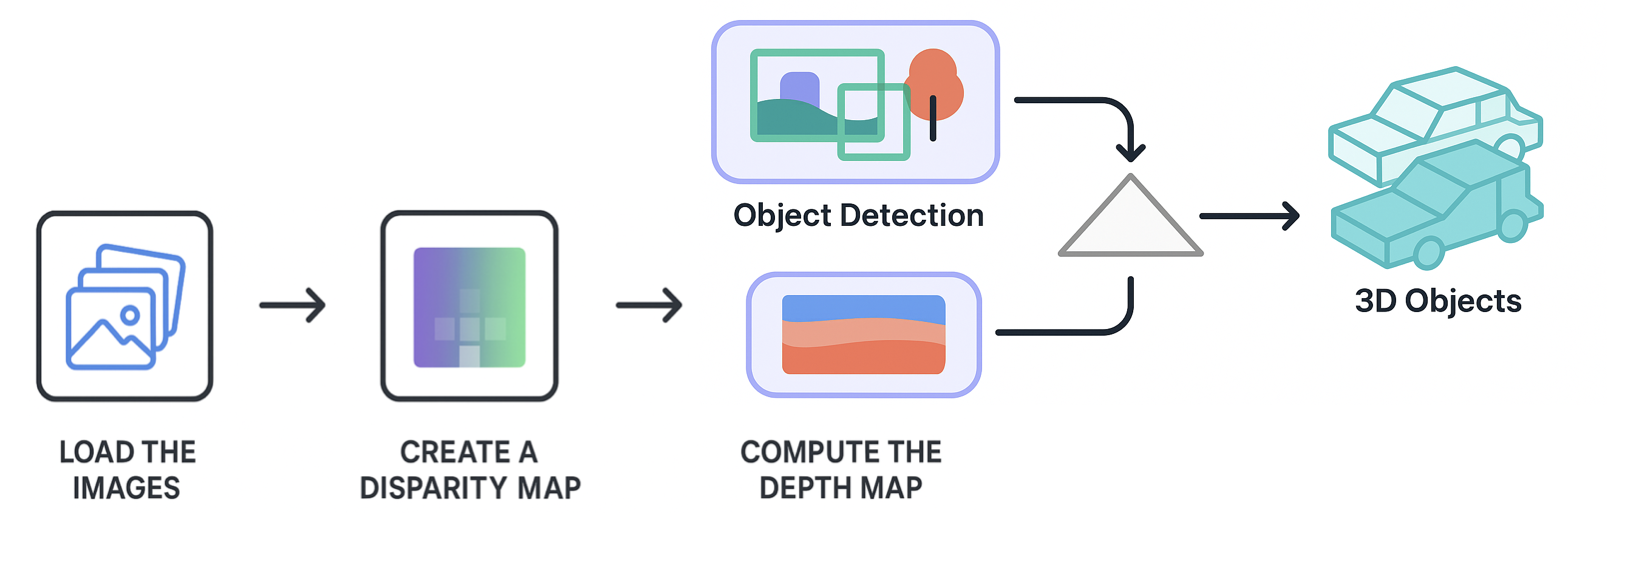

## 1 - **Load the Images**
We'll begin simply by loading the images. To load the images, you can use the "wget" command line, which will get everything ready for you.

In [ ]:
!wget https://stereo-vision.s3.eu-west-3.amazonaws.com/stereo_data.zip && jar xf stereo_data.zip
!pip install open3d

In [ ]:

import os
os.chdir("stereo_data")

### Additional Libraries

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
from ipywidgets import interact, interactive, fixed
import glob

### Load image data

In [ ]:
images_L = sorted(glob.glob("left/*.png"))
images_R = sorted(glob.glob("right/*.png"))
labels = sorted(glob.glob("labels/*.txt"))
calib_files = sorted(glob.glob("calib/*.txt"))

print("There are",len(images_L),"images")
index = 0
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(cv2.imread(images_L[index]), cv2.COLOR_BGR2RGB))
ax1.set_title('Image Left', fontsize=30)
ax2.imshow(cv2.cvtColor(cv2.imread(images_R[index]), cv2.COLOR_BGR2RGB))
ax2.set_title('Image Right', fontsize=30)

### Dataset Questions
We are extracting these images from the KITTI dataset, therefore, all the data is public. Assuming we'll need this later, can you figure out...
* What is the baseline?
* What is the focal length?
To help you, you can read more about the setup used here: https://www.cvlibs.net/datasets/kitti/setup.php

## 2 - **Calculate the Disparity Map**
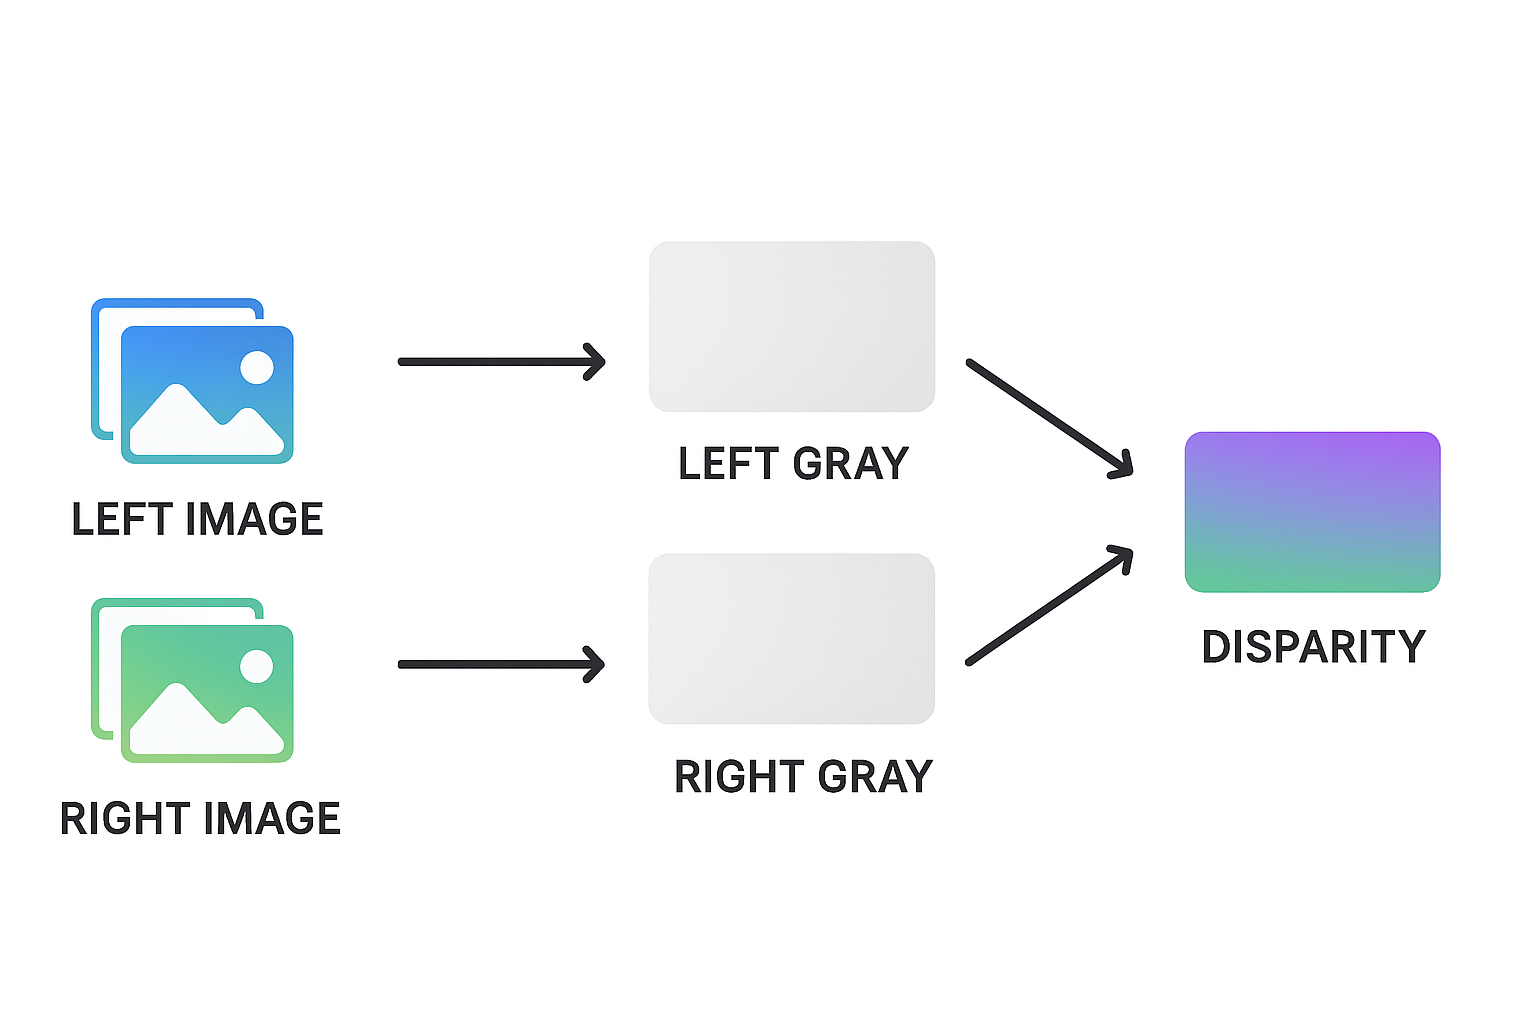

### Basic Disparity Estimation
There are 2 very simple OpenCV algorithms we can use for disparity estimation called StereoBM and StereoSGBM. Next week, you'll go in the details of how these work, but for now, I'd like you to simply try and use them.
* BM stands for Block Matching
* SGBM stands for Semi-Global Block Matching

In [ ]:
def disparity_estimator(img_l_path, img_r_path):
    # Read the images
    image_left = cv2.imread(img_l_path)
    image_right = cv2.imread(img_r_path)

    # Convert the images to grayscale
    img_left_gray = cv2.cvtColor(image_left, cv2.COLOR_BGR2GRAY)
    img_right_gray = cv2.cvtColor(image_right, cv2.COLOR_BGR2GRAY)

    # Experiment with disparities & block size
    num_disparities = 112
    block_size = 5

    #Create a Block Matcher and Compute the disparity
    new_image = cv2.StereoBM_create(numDisparities=num_disparities,blockSize=block_size)
    new_image = new_image.compute(img_left_gray, img_right_gray).astype(np.float32)/16

    #Visualize it
    plt.imshow(new_image, cmap="cividis")
    plt.show()

In [ ]:
disparity_estimator(images_L[0], images_R[0])

### Compute And Display the Disparity

In [ ]:
def compute_disparity(image, img_pair, num_disparities=6*16, block_size=11, window_size=6, matcher="stereo_sgbm", show_disparity=True):
    """
    Create a Stereo BM or Stereo SGBM Matcher
    Compute the Matching
    Display the disparity image
    Return it
    """
    if matcher == "stereo_bm":
        new_image = cv2.StereoBM_create(numDisparities=num_disparities,blockSize=block_size)
    elif matcher == "stereo_sgbm":
        '''
        Understand parameters: https://docs.opencv.org/3.4/d2/d85/classcv_1_1StereoSGBM.html
        '''
        new_image = cv2.StereoSGBM_create(minDisparity=0, numDisparities=num_disparities, blockSize=block_size, P1=8 * 3 * window_size ** 2,
            P2=32 * 3 * window_size ** 2, mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)

    new_image = new_image.compute(image, img_pair).astype(np.float32)/16
    if (show_disparity==True):
        plt.figure(figsize = (40,20))
        plt.imshow(new_image, cmap="cividis")
        plt.show()
    return new_image

In [ ]:
"""
NUM_DISPARITIES:
the disparity search range.
For each pixel algorithm will find the best disparity from 0 (default minimum disparity) to numDisparities.
The search range can then be shifted by changing the minimum disparity.
--> The value is always greater than zero. In the current implementation, this parameter must be divisible by 16.
"""
num_d = (0,512,16)

"""
BLOCK SIZE: the linear size of the blocks compared by the algorithm.
Matched block size. It must be an odd number >=1 .
Normally, it should be somewhere in the 3..11 range.
--> Larger block size implies smoother, though less accurate disparity map.
--> Smaller block size gives more detailed disparity map, but there is higher chance for algorithm to find a wrong correspondence.
"""
b_s = (1,19,2)

"""
WINDOW SIZE:
Default 3; 5; 7 for SGBM reduced size image; 15 for SGBM full size image (1300px and above); 5 Works nicely
"""
window_s = (1,13,2)

"""
MIN DISPARITY
min: Minimum possible disparity value.
Normally, it is zero but sometimes rectification algorithms can shift images, so this parameter needs to be adjusted accordingly.
max: has to be dividable by 16 f. E. HH 192, 256, default:
#
"""

In [ ]:
#Reading the Left Images
img_left = cv2.imread(images_L[index]) #OpenCV reads in BGR
img_left_gray = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
# Reading the right Images
img_right = cv2.imread(images_R[index]) #OpenCV reads in BGR
img_right_gray = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

In [ ]:
disparity_left = interactive(compute_disparity, image=fixed(img_left_gray), img_pair = fixed(img_right_gray), num_disparities=num_d, block_size=b_s, window_size=window_s, matcher=["stereo_sgbm", "stereo_bm"])
display(disparity_left)

In [ ]:
disparity_right = compute_disparity(img_right_gray, img_pair=img_left_gray, num_disparities=disparity_left.kwargs["num_disparities"], block_size=disparity_left.kwargs["block_size"], window_size=disparity_left.kwargs["window_size"], matcher=disparity_left.kwargs["matcher"])
disparity_left = disparity_left.result

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(disparity_left,  cmap="inferno") # or CMRmap_r
ax1.set_title('Disparity Left', fontsize=30)
ax2.imshow(disparity_right, cmap="inferno")
ax2.set_title('Disparity Right', fontsize=30)

#cv2.imwrite("output/disparity.png",disparity_left)

### Analysis, what is a disparity map?

In [ ]:
squared = disparity_left.copy()
print("squared", squared)

cv2.rectangle(squared, pt1=(400,100), pt2=(800,300), color=(255,0,0), thickness=10)
plt.imshow(squared, cmap="inferno")

print(disparity_left[100:300, 400:800])

The disparity map is the size of the image.<p>
At the location of each pixel, you get the distance in pixel to travel to get the correspondance in the other image.<p>

*   Objects that are far away are smaller in pixels, and the disparity value will be lower
*   Close objects will appear at different angles and thus need a higher disparity value



**From now on, we'll only focus on the image "disparity left".**

## Step 3 - **Compute Depth Map**
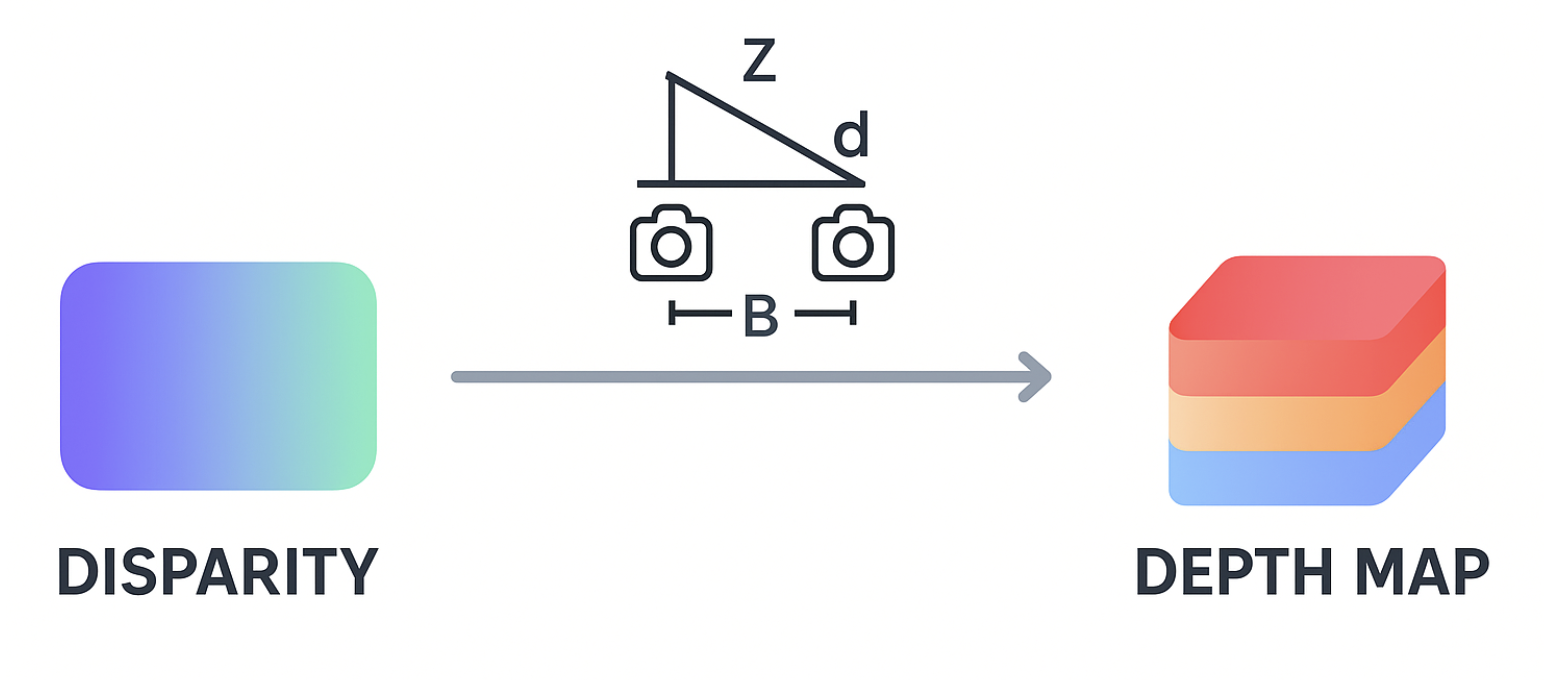

### Get Calibration Parameters

In [ ]:
print("Calibration file for image: ", open(calib_files[index]))
print(open(calib_files[index]).read())

The following lines will help us parse the dataset to collect desired information.

Note: We are skipping P0 and P1 as they represent grayscale data.

In [ ]:
# Original
def get_calibration_parameters(file):
    with open(file, 'r') as f:
        fin = f.readlines()
        for line in fin:
            if line[:2] == 'P2':
                p_left = np.array(line[4:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:2] == 'P3':
                p_right = np.array(line[4:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:7] == 'R0_rect':
                p_ro_rect = np.array(line[9:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:14] == 'Tr_velo_to_cam':
                p_velo_to_cam = np.array(line[16:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:14] == 'Tr_imu_to_velo':
                p_imu_to_velo = np.array(line[16:].strip().split(" ")).astype('float32').reshape(3,-1)
    return p_left, p_right, p_ro_rect, p_velo_to_cam, p_imu_to_velo

p_left, p_right, p_ro_rect, p_velo_to_cam, p_imu_to_velo = get_calibration_parameters(calib_files[index])

np.set_printoptions(precision=5)
print("Left P Matrix")
print(p_left)
print("Right P Matrix")
print(p_right)
print("RO to Rect Matrix")
print(p_ro_rect)
print("Velodyne to Camera Matrix")
print(p_velo_to_cam)
print("IMU to Velodyne Matrix")
print(p_imu_to_velo)

### Compute Depth from Disparity



**So how do we compute the Depth from the disparity? Going back to the class, we remember this formula:**

From our formulas, we defined the following:
![](https://miro.medium.com/max/1152/0*jToKsSZEjNhKaV9S.png) <p>

Awesome! So how do we get F and B? Should we make it up? <p>
Not exactly...

**Actually, this value can be found in P, the matrix you just calculated!**




Let me show you the value of P, according to the KITTI Dataset paper:

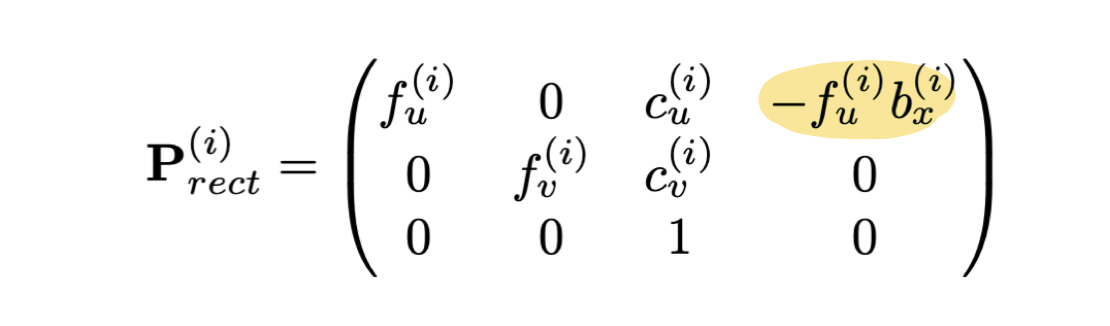

Okay, now, if you scroll up just a bit, you will see the P value we have for left and right!!!

**Don't you see it? We have f*b in P!** It's burried within P! But if you notice, P left and P right don't have the same top right value...
* P_left has 4.48
* P_right has -339.5 🤪

So, which one to use?

Well, neither! And to explain, let me show you this graph:
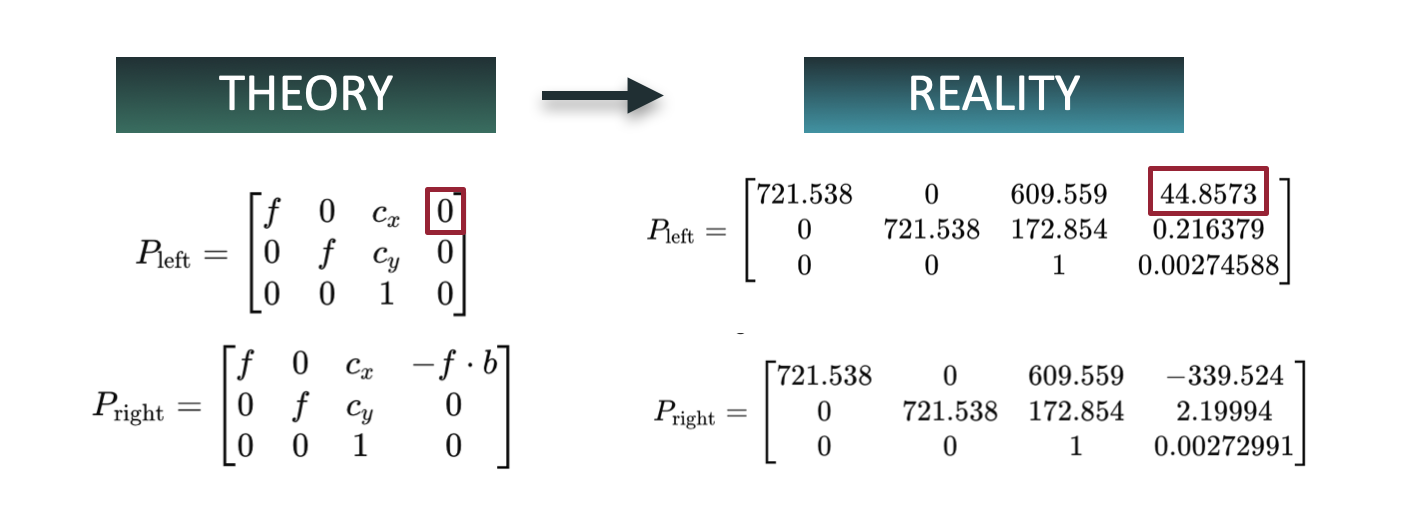

See? We are supposed to use **-f*b** in P_right, but **ONLY** if the P_left top right value is 0. In this case, the calibration that happened shifted this, so we are going to use this value, but subtract with the actual top right corner value we have (44.8).

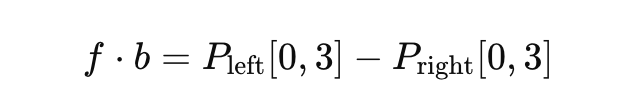

👉🏼 Value to use: f*b = -339.524-44.8573= **384,38**

From there, you can already calculate the baseline, with the formula b = 384/721 ~0.53 (in KITTI setup, you can see 0.54).

But let's not get lost too much here...

In [ ]:
def decompose_projection_matrix(p):
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = t / t[3] # Back from homogeneous
    return k, r, t

# Decompose each matrix
k_left, r_left, t_left = decompose_projection_matrix(p_left)
k_right, r_right, t_right = decompose_projection_matrix(p_right)

# Display the matrices
print("k_left \n", k_left)
print("\nr_left \n", r_left)
print("\nt_left \n", t_left)
print("\nk_right \n", k_right)
print("\nr_right \n", r_right)
print("\nt_right \n", t_right)

In [ ]:
abs(t_left[0] - t_right[0])

In [ ]:
def calc_depth_map(disp_left, k_left, t_left, t_right):
    # Get the focal length from the K matrix
    f = k_left[0, 0]
    # Get the distance between the cameras from the t matrices (baseline)
    b = abs(t_left[0] - t_right[0]) #On the setup page, you can see 0.54 as the distance between the two color cameras (http://www.cvlibs.net/datasets/kitti/setup.php)
    # Replace all instances of 0 and -1 disparity with a small minimum value (to avoid div by 0 or negatives)
    disp_left[disp_left == 0] = 0.1
    disp_left[disp_left == -1] = 0.1
    # Initialize the depth map to match the size of the disparity map
    depth_map = np.ones(disp_left.shape, np.single)
    # Calculate the depths
    depth_map[:] = f * b / disp_left[:]
    return depth_map

# Get the depth map by calling the above function
depth_map_left = calc_depth_map(disparity_left, k_left, t_left, t_right)
depth_map_right = calc_depth_map(disparity_right, k_right, t_right, t_left)

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(depth_map_left,cmap='flag') # or flag
ax1.set_title('Depth Left', fontsize=30)
ax2.imshow(depth_map_right,cmap='flag') # or flag
ax2.set_title('Depth Right', fontsize=30)

In [ ]:
!mkdir output
np.save('output/depth_map.npy', depth_map_left)

## Step 4 - **3D Object Detection**
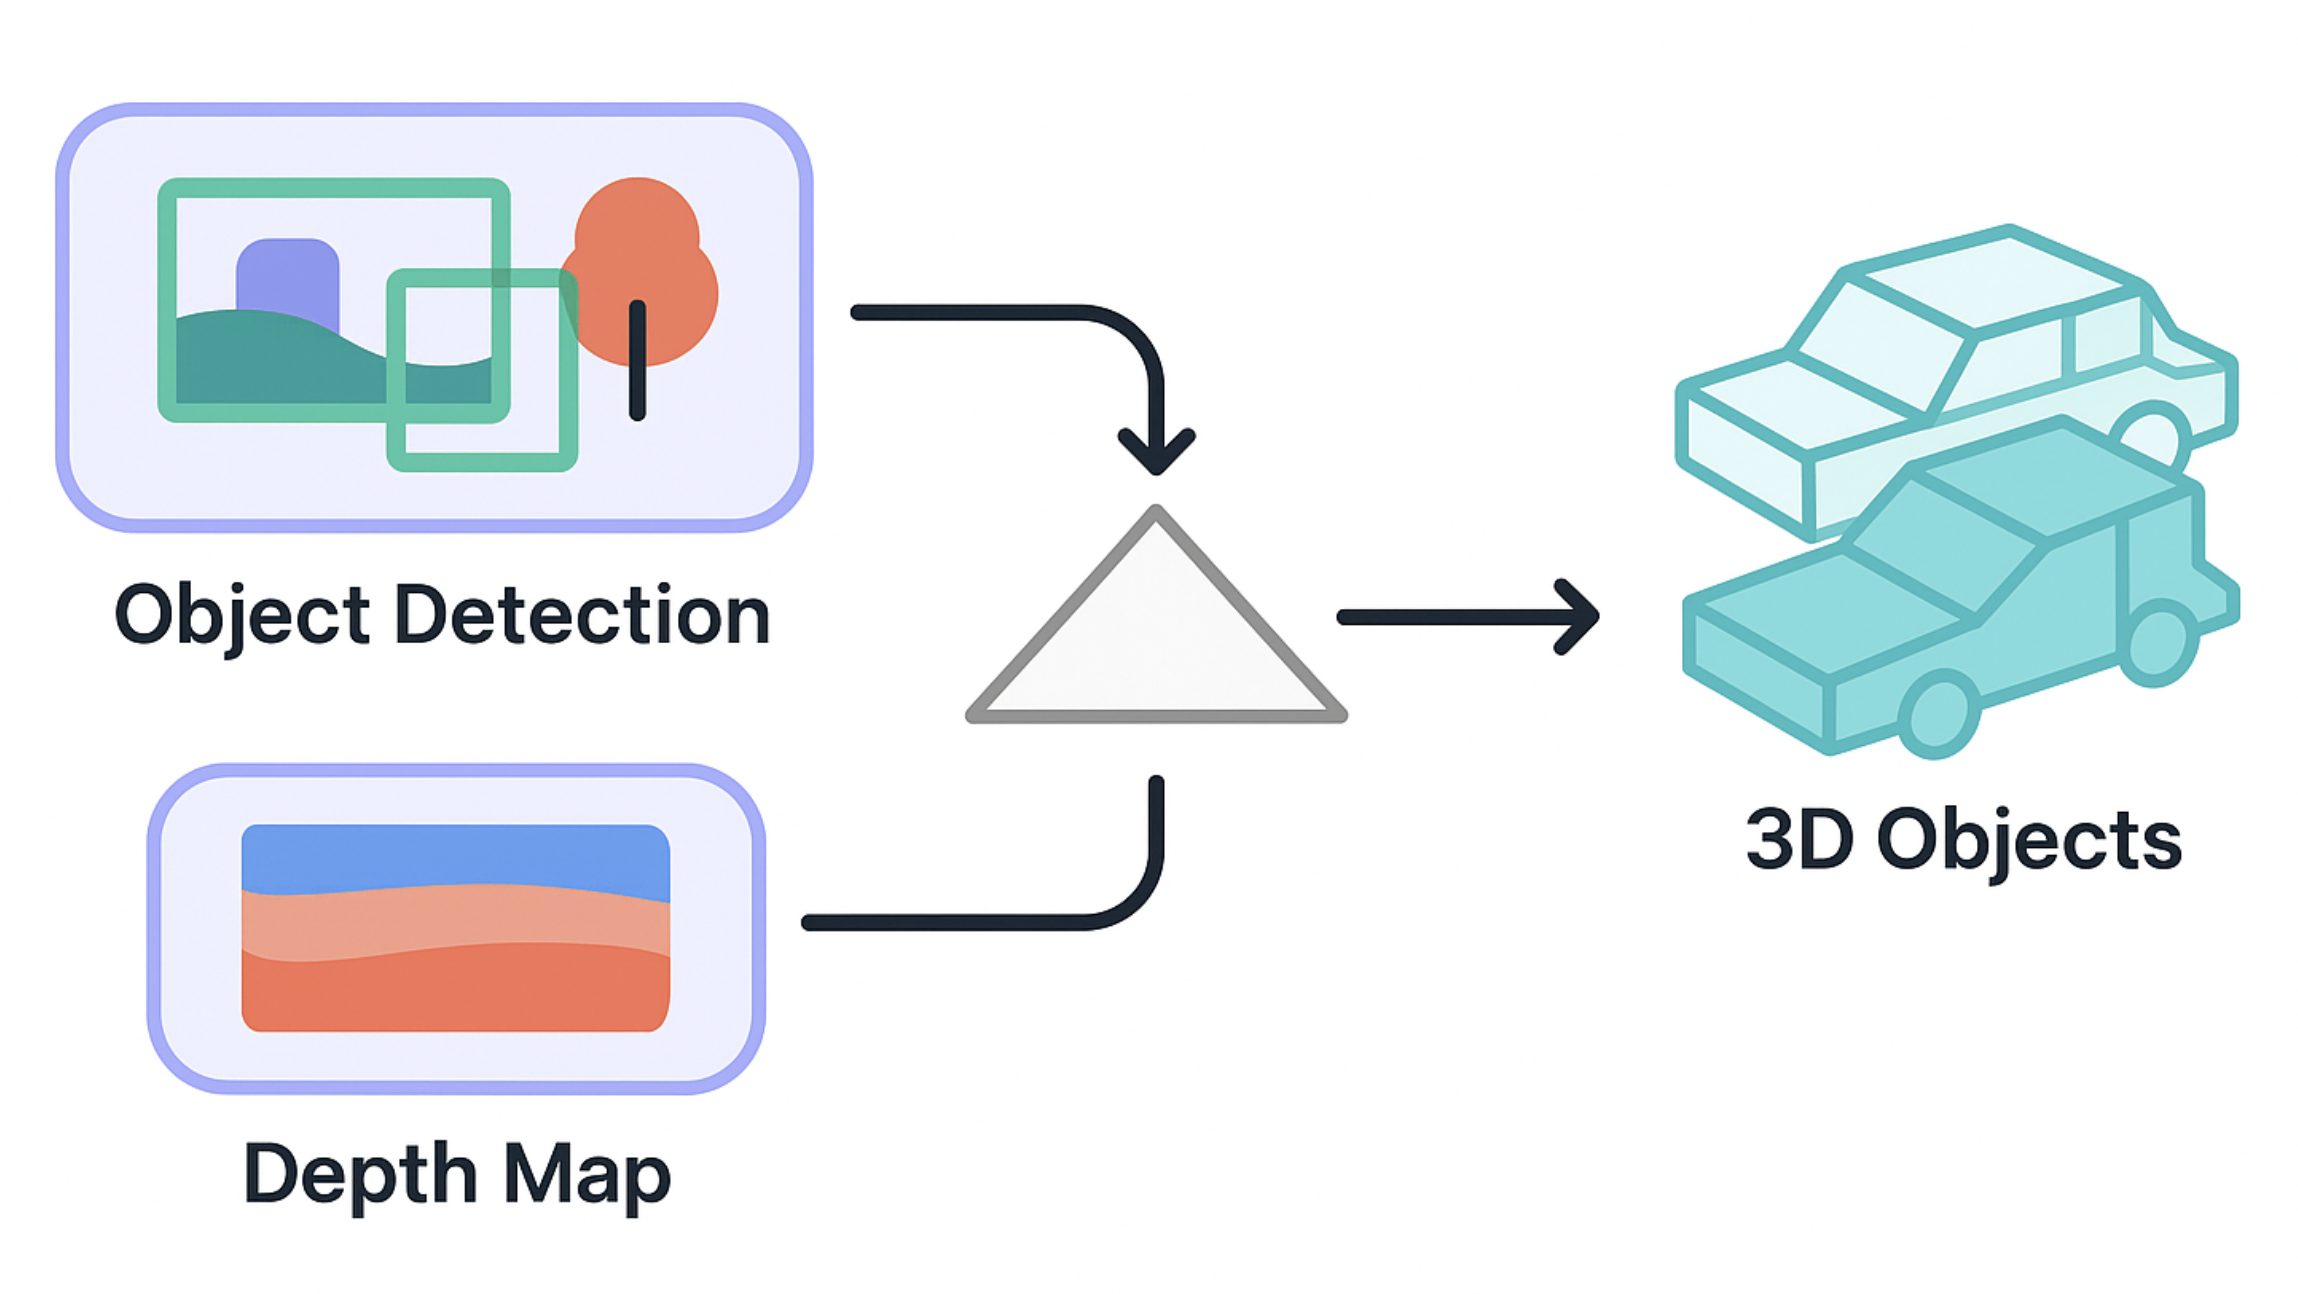

We're going to use Yolov11

Of course, you are free to experiment with YOLOv5, v6, v7, or whatever version is trendy. But let's focus on just getting some boxes and finding the depth of them.

In [ ]:
!pip install ultralytics #packages installed for me: ultralytics-8.3.51 ultralytics-thop-2.0.13

In [ ]:
!wget https://stereo-vision.s3.eu-west-3.amazonaws.com/yolo11n.pt  #download yolo11n.pt

In [ ]:
##//
from ultralytics import YOLO


In [ ]:

# Load a model
model = YOLO("yolo11n.pt")

In [ ]:
import time
def run_obstacle_detection(img_orig):
    start_time=time.time()
    img = img_orig.copy()

    results = model.predict(img)
    result = results[0]
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs

    # Draw Boxes
    rectangle_thickness=1
    text_thickness=1
    boxesfiltered = []

    for box in boxes:
        objecttype = result.names[int(box.cls[0])]
        if objecttype=='person' or objecttype=='car':
            boxesfiltered.append(True)

        else:
            boxesfiltered.append(False)
    exec_time = time.time() - start_time
    #print("time: {:.2f} ms".format(exec_time * 1000))


    newlabels = []
    for label in boxes.cls[boxesfiltered]:
        newlabels.append(result.names[int(label)])
    return img, boxes.xywhn[boxesfiltered], newlabels , boxes.conf[boxesfiltered]

result, pred_bboxes, pred_classes, pred_conf = run_obstacle_detection(img_left)

# Run the next cell below to draw the predictions

In [ ]:
def draw_predictions(pred_bboxes, pred_classes, pred_conf, img):
    rectangle_thickness = 3
    text_thickness = 3
    h, w, _ = img.shape
    for box,cls,conf in zip(pred_bboxes,pred_classes,pred_conf):
        x1 = int(box[0]*w - box[2]*w*0.5) # center_x - width /2
        y1 = int(box[1]*h-box[3]*h*0.5) # center_y - height /2
        x2 = int(box[0]*w + box[2]*w*0.5) # center_x + width/2
        y2 = int(box[1]*h+box[3]*h*0.5) # center_y + height/2
        objecttype = cls
        if objecttype=='person' or objecttype=='car':
            cv2.rectangle(img, (x1,y1),
                          (x2,y2), (30, 40, 255), rectangle_thickness)
            confidence = conf.cpu().numpy().round(2)
            cv2.putText(img, f"{objecttype} - "+str(confidence),
                        (x1, y1 - 3),
                        cv2.FONT_HERSHEY_PLAIN, 1, (30, 40, 255), text_thickness)

    return img

result = draw_predictions(pred_bboxes,pred_classes,pred_conf,result)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
cv2.imwrite("output/result_yolo.png", result)

In [ ]:
pwd

### Let's take a minute and analyze YOLO output

In [ ]:
pred_bboxes

In [ ]:
h, w, _ = img_left.shape
testing_box = pred_bboxes[0]
print("original box", testing_box)
print("center_x:",testing_box[0]*w)
print("center_y",testing_box[1]*h)
print("width:", testing_box[2]*w)
print("height:",testing_box[3]*h)

In [ ]:
def find_distances(depth_map, pred_bboxes, img, method="center"):
    """
    Go through each bounding box and take a point in the corresponding depth map.
    It can be:
    * The Center of the box
    * The average value
    * The minimum value (closest point)
    * The median of the values
    """
    depth_list = []
    h, w, _ = img.shape
    for box in pred_bboxes:
        # Move the tensor to CPU and convert to NumPy before accessing values
        box_np = box.cpu().numpy()
        x1 = int(box_np[0]*w - box_np[2]*w*0.5) # center_x - width /2
        y1 = int(box_np[1]*h - box_np[3]*h*0.5) # center_y - height /2
        x2 = int(box_np[0]*w + box_np[2]*w*0.5) # center_x + width/2
        y2 = int(box_np[1]*h + box_np[3]*h*0.5) # center_y + height/2

        # Ensure coordinates are within image bounds
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(w, x2)
        y2 = min(h, y2)

        print(np.array([x1, y1, x2, y2])) # Now this will work as box_np is on CPU and converted to int
        obstacle_depth = depth_map[y1:y2, x1:x2]
        if obstacle_depth.size == 0:
            depth_list.append(None)  # skip invalid boxes
            continue

        if method == "closest":
            value = np.min(obstacle_depth)
        elif method == "average":
            value = np.mean(obstacle_depth)
        elif method == "median":
            value = np.median(obstacle_depth)
        else:  # default: center point
            cx = int(box_np[0]*w)
            cy = int(box_np[1]*h)
            if 0 <= cy < h and 0 <= cx < w:
                value = depth_map[cy, cx]
            else:
                value = None

        depth_list.append(value)

    return depth_list

depth_list = find_distances(depth_map_left, pred_bboxes, img_left, method="center")
print(depth_list)

In [ ]:
def add_depth(depth_list, result, pred_bboxes):
    h, w, _ = result.shape
    res = result.copy()
    for i, distance in enumerate(depth_list):
        cv2.line(res,(int(pred_bboxes[i][0]*w - pred_bboxes[i][2]*w/2),int(pred_bboxes[i][1]*h - pred_bboxes[i][3]*h*0.5)),(int(pred_bboxes[i][0]*w + pred_bboxes[i][2]*w*0.5),int(pred_bboxes[i][1]*h + pred_bboxes[i][3]*h*0.5)),(0,255,0),2)
        cv2.line(res,(int(pred_bboxes[i][0]*w + pred_bboxes[i][2]*w/2),int(pred_bboxes[i][1]*h - pred_bboxes[i][3]*h*0.5)),(int(pred_bboxes[i][0]*w - pred_bboxes[i][2]*w*0.5),int(pred_bboxes[i][1]*h + pred_bboxes[i][3]*h*0.5)),(0,255,0),2)
        cv2.putText(res, '{0:.2f} m'.format(distance), (int(pred_bboxes[i][0]*w - pred_bboxes[i][2]*w*0.5),int(pred_bboxes[i][1]*h)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2, cv2.LINE_AA)
    return res

res = add_depth(depth_list, result, pred_bboxes)

plt.figure(figsize = (40,20))
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
#cv2.imwrite("output/result.png", cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

### Compare with the Ground Truth (Labels)

In [ ]:
def ground_truth_display(img_label, index):
    with open(labels[index], 'r') as f:
            fin = f.readlines()
            for line in fin:
                if line.split(" ")[0] != "DontCare":
                    #print(line)
                    x1_value = int(float(line.split(" ")[4]))
                    y1_value = int(float(line.split(" ")[5]))
                    x2_value = int(float(line.split(" ")[6]))
                    y2_value = int(float(line.split(" ")[7]))
                    distance = float(line.split(" ")[13])
                    cv2.line(img_label,(x1_value, y1_value), (x2_value, y2_value),(0,205,0),2)
                    cv2.line(img_label,(x1_value, y2_value), (x2_value, y1_value),(0,205,0),2)
                    cv2.rectangle(img_label, (x1_value, y1_value), (x2_value, y2_value), (0,205,0), 5)
                    cv2.putText(img_label, str(distance), (int(x1_value),int((y1_value+y2_value)/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2, cv2.LINE_AA)
    return img_label

img_label = img_left.copy()
img_label = ground_truth_display(img_label, index)
plt.figure(figsize=(20,40))
plt.imshow(cv2.cvtColor(img_label, cv2.COLOR_BGR2RGB))
plt.show()

## Step 5 - **The Full 3D Object Detection Pipeline**

In [ ]:
def pipeline (img_left, img_right, p_left, p_right, index):
    #TODO: Do the pipeline!
    disp_left = compute_disparity(image=img_left, img_pair = img_right, num_disparities=96, block_size=11, window_size=7, matcher="stereo_sgbm")
    # Decompose each matrix
    k_left, r_left, t_left = decompose_projection_matrix(p_left)
    k_right, r_right, t_right = decompose_projection_matrix(p_right)

    depth_map = calc_depth_map(disp_left, k_left, t_left, t_right)

    result, pred_bboxes, pred_classes, pred_conf = run_obstacle_detection(img_left)
    depth_list = find_distances(depth_map, pred_bboxes, img_left, method="center")
    final = add_depth(depth_list, result, pred_bboxes)
    return final

In [ ]:
# Let's test on 1 frame

index  = 4
img_left = cv2.imread(images_L[index])
img_right = cv2.imread(images_R[index])
p_left, p_right, p_ro_rect, p_velo_to_cam, p_imu_to_velo = get_calibration_parameters(calib_files[index])

final = pipeline(img_left, img_right, p_left, p_right, index)
plt.imshow(cv2.cvtColor(final,cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
ground_truth = ground_truth_display(img_left, index)

f, (ax1, ax2) = plt.subplots(1,2)
ax1.set_title("You")
ax1.imshow(cv2.cvtColor(final,cv2.COLOR_BGR2RGB))
ax2.set_title("The program we told you not to worry about")
ax2.imshow(cv2.cvtColor(ground_truth,cv2.COLOR_BGR2RGB))
plt.show()

# Outstanding Points 💯
What separates normal folks and those who get outstanding results is the willingness to do the extra 20%. In this case, the extra 20% means going further than your original assignment. It can be:
* By going more in depth inside the algorithms BM/SGBM
* By building a video of your depth map
* By using Deep Learning
* ...? Can you think of a way to do an extra 20%?

The way I like to think about it is, if you're to be a 3D Computer Vision expert, shouldn't you, at the very least, have a comparison video of the different types of Stereo Vision algorithms and their outcomes? Shouldn't you, at the very least, have a video going over a depth map?

I am going to show you two of the ways you can do this... and then — I invite you to continue in your squad!

## **Build a 3D Point Cloud (3D Reconstruction)**

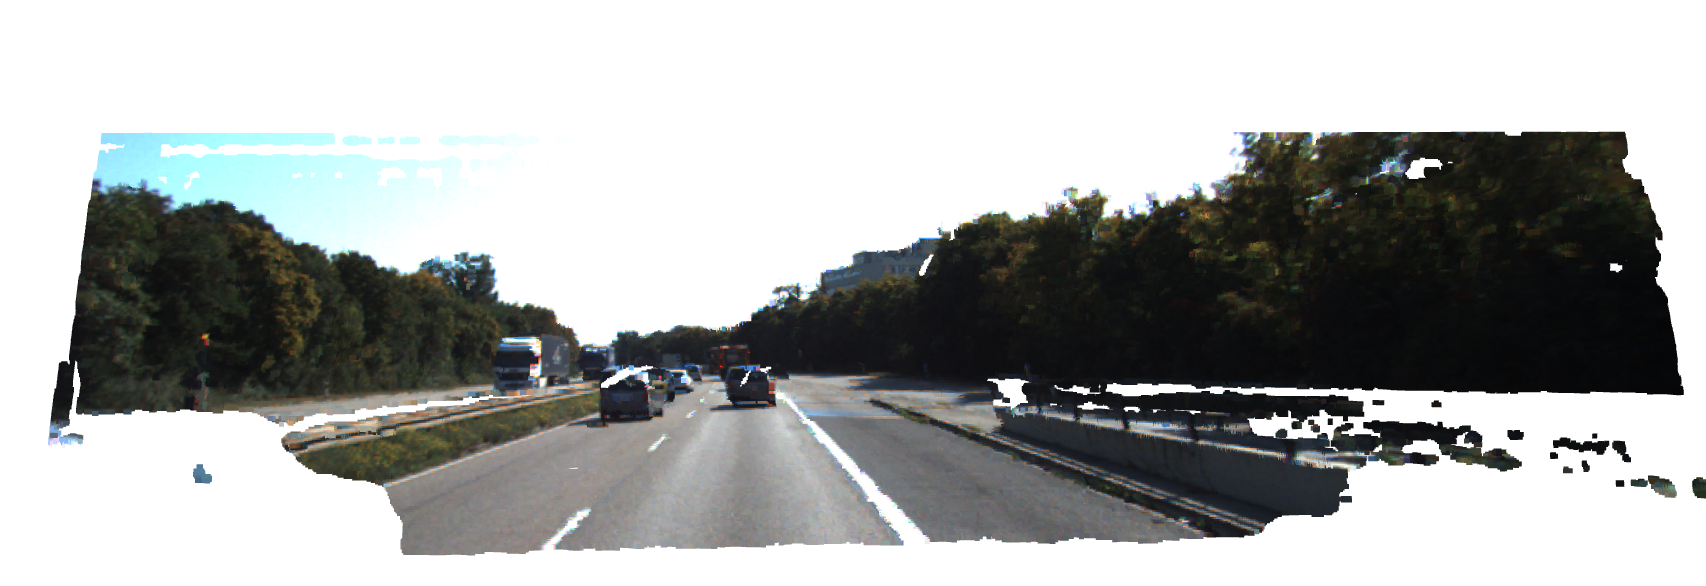

OpenCV uses the Q Matrix is used to get a 3D Point Cloud.
If you've done the calibration notebook, you saw this Q matrix as "disparity to depth".

**Structure of the Q Matrix:**<p>
![](https://answers.opencv.org/upfiles/15222662547364629.png)

It is obstained through stereo calibration, in particular, the function
```
Q = np.zeros(4,4)
cv2. stereoRectify (cameraMatrixLeft, CameraMatrixRight, distortion_coefficients_left, distortion_coefficients_right, image_size, R, T, R1, R2, P1, P2, Q)
```

Then, StereoRectify modifies the Q matrix.

**It then can be used the following:**<p>
![](https://answers.opencv.org/upfiles/1522266963686882.png)


In [ ]:
# Calculate depth-to-disparity
cam1 = p_left[:,:3] # left image - P2
cam2 = p_right[:,:3] # right image - P3

print(p_left)
print(cam1)

Tmat = np.array([0.54, 0., 0.]) #On the setup page, you can see 0.54 as the distance between the two color cameras (http://www.cvlibs.net/datasets/kitti/setup.php)

Q = np.zeros((4,4))

cv2.stereoRectify(cameraMatrix1 = cam1,cameraMatrix2 = cam2, \
                  distCoeffs1 = 0, distCoeffs2 = 0, \
                  imageSize = img_left.shape[:2], \
                  R = np.identity(3), T = Tmat, \
                  R1 = None, R2 = None, \
                  P1 =  None, P2 =  None, Q = Q);

print("Disparity To Depth")
print(Q)

In [ ]:
points = cv2.reprojectImageTo3D(disparity_left.copy(), Q)

#reflect on x axis

reflect_matrix = np.identity(3)
reflect_matrix[0] *= -1
points = np.matmul(points,reflect_matrix)


#extract colors from image
#img_left_color = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
#colors = cv2.cvtColor(img_left_color, cv2.COLOR_BGR2RGB)
img_left = cv2.imread(images_L[index])
colors = cv2.cvtColor(img_left.copy(),cv2.COLOR_BGR2RGB)

#filter by min disparity
mask = disparity_left > disparity_left.min()
out_points = points[mask]
out_colors = colors[mask]

#filter by dimension
#idx = np.fabs(out_points[:,0]) < 4.5
#out_points = out_points[idx]
out_colors = out_colors.reshape(-1, 3)
#out_colors = out_colors[idx]

In [ ]:
def write_ply(fn, verts, colors):
    ply_header = '''ply
    format ascii 1.0
    element vertex %(vert_num)d
    property float x
    property float y
    property float z
    property uchar red
    property uchar green
    property uchar blue
    end_header
    '''
    out_colors = colors.copy()
    verts = verts.reshape(-1, 3)
    verts = np.hstack([verts, out_colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

file_name = "output/out"+str(index)+".ply"
write_ply(file_name, out_points, out_colors)

At this point, I highly recommend downloading the file on your computer and visualizing it using a software like MeshLab. Otherwise, we can also try the code below.

## **Build a Depth Map Video** ✅

In [ ]:
def pipeline_video(img_left, img_right, p_left, p_right, idx):
    "For a pair of 2 Calibrated Images"
    #Reading the Left Images
    img_left_gray = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
    # Reading the right Images
    img_right_gray = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
    # Compute the Disparity Map
    disparity = compute_disparity(img_left_gray, img_pair=img_right_gray, num_disparities=112, block_size=5, window_size=7, matcher="stereo_sgbm", show_disparity=False)
    normalized_image = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX).astype("uint8")
    colormapped_image = cv2.applyColorMap(normalized_image, cv2.COLORMAP_JET)
    # Get the Calibration Parameters
    k_left, r_left, t_left = decompose_projection_matrix(p_left)
    k_right, r_right, t_right = decompose_projection_matrix(p_right)

    depth_map = calc_depth_map(disparity, k_left, t_left, t_right)
    return depth_map

In [ ]:
left_video = sorted(glob.glob("2011_09_30_drive_0016_sync/image_02/data/*.png")) #data/left/*.png"))
right_video = sorted(glob.glob("2011_09_30_drive_0016_sync/image_03/data/*.png"))

result_video = []

for idx,img in enumerate(left_video):
    left_img = cv2.imread(left_video[idx])
    right_img = cv2.imread(right_video[idx])
    result_video.append(pipeline_video(left_img, right_img, p_left, p_right,idx))
    print(idx)

In [ ]:
out = cv2.VideoWriter('output/2011_09_30_drive_0016_sync.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (w,h))

for i, frame in enumerate(result_video):
    # Ensure frame is uint8
    if frame.dtype != 'uint8':
        # If values are floats in range [0,1]
        if frame.max() <= 1.0:
            frame = (frame * 255).astype('uint8')
        else:  # If values are floats in [0,255]
            frame = frame.astype('uint8')

    # Save individual frame
    cv2.imwrite(f"output/2011_09_26_drive_0017_sync/{str(i).zfill(5)}.png", frame)

    # Write to video
    out.write(frame)

out.release()

In [ ]:
left_video = sorted(glob.glob("2011_09_26_drive_0005_sync/2011_09_26/2011_09_26_drive_0005_sync/image_02/data/*.png")) #data/left/*.png"))
right_video = sorted(glob.glob("2011_09_26_drive_0005_sync/2011_09_26/2011_09_26_drive_0005_sync/image_03/data/*.png"))
#left_video = glob.glob("data/video/left/*.png")
#right_video = glob.glob("data/video/right/*.png")

result_video = []

for idx,img in enumerate(left_video):
    left_img = cv2.imread(left_video[idx])
    right_img = cv2.imread(right_video[idx])
    result_video.append(pipeline(left_img, right_img, p_left, p_right, idx))
    print(idx)

(w,h,_) = left_img.shape
out = cv2.VideoWriter('output/out0005.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (w,h))

for i in range(len(result_video)):
    out.write(cv2.cvtColor(result_video[i], cv2.COLOR_BGR2RGB))
out.release()

## **Deep Learning Based Depth Estimation** ✅

In [ ]:
!git clone https://github.com/nianticlabs/monodepth2.git
!cd monodepth2

In [ ]:
import sys
sys.path.append('/content/stereo_data/monodepth2')

In [ ]:
input_image = cv2.imread("/content/stereo_data/left/000009.png")

input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

input_image.shape[:2]

In [ ]:
import cv2
import numpy as np
import torch
from monodepth2.networks import DepthDecoder, ResnetEncoder
from monodepth2.utils import download_model_if_doesnt_exist
from google.colab.patches import cv2_imshow

# Download the model weights
model_name = "mono_640x192"
download_model_if_doesnt_exist(model_name)

# Load the model components
encoder_path = f"/content/stereo_data/models/{model_name}/encoder.pth"
depth_decoder_path = f"/content/stereo_data/models/{model_name}/depth.pth"

# Load the encoder
encoder = ResnetEncoder(18, False)
loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

# Load the depth decoder
depth_decoder = DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))
loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

# Set to evaluation mode
encoder.eval()
depth_decoder.eval()

# Read and preprocess an image
input_image = cv2.imread("/content/stereo_data/left/000009.png")

input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
original_height, original_width = input_image.shape[:2]
input_image = cv2.resize(input_image, (640, 192))
input_image = input_image.transpose(2, 0, 1)
input_image = np.expand_dims(input_image, 0)
input_image = torch.from_numpy(input_image).float() / 255.0

# Predict depth
with torch.no_grad():
    features = encoder(input_image)
    outputs = depth_decoder(features)

# Generate the depth map
disp = outputs[("disp", 0)]
disp_resized = torch.nn.functional.interpolate(disp, (original_height, original_width), mode="bilinear", align_corners=False)

# Saving numpy file
depth_map = disp_resized.squeeze().cpu().numpy()
np.save("depth_map.npy", depth_map)

# Visualize the result
disp_resized_np = disp_resized.squeeze().cpu().numpy()
cv2_imshow(disp_resized_np)


In [ ]:
print(disp_resized_np*255)

In [ ]:
print(np.min(disp_resized_np))

In [ ]:
plt.imshow(disp_resized_np*255, cmap="magma")
plt.show()

In [ ]:
print(np.max(np.load('depth_map.npy')))

In [ ]:
test_depth = calc_depth_map(disp_resized_np, k_left, t_left, t_right)

In [ ]:
print((test_depth))

In [ ]:
plt.imshow(test_depth, cmap="magma")

## **Finale 3D Video Generation**
Finally, let's build a cool video showing 3D Reconstruction in action!

First, we'll install Open3D to load the point cloud.

In [ ]:
import open3d as o3d

Now we read it:

In [ ]:

pcd = o3d.io.read_point_cloud("output/out4.ply")

The rest may work on Jupyter Notebooks or locally, but may fail on Colab.

In [ ]:
# For Viewing on computer (does not run on colab)
o3d.visualization.draw_geometries([pcd],
                                  zoom=0.008,
                                  front=[0 ,0.01, 5],
                                  lookat=[0,0.1,-10],
                                  up=[0,0,-1])

In [ ]:
# Different Angle for Viewing on computer (does not run on colab)
o3d.visualization.draw_geometries([pcd],
                                  zoom=0.008,
                                  front=[ 0.27028868132726824, -0.0036027827686225091, 0.96277258410420508 ],
                                  lookat=[0,0.1,-10],
                                  up=[ -0.01446335938247148, 0.99986496068000874, 0.0078020279247221856 ])


In [ ]:
# For Saving to File (may not run on colab)
# Create the visualizer
vis = o3d.visualization.Visualizer()
vis.create_window(visible=False)

# Add geometry (e.g., point cloud)
vis.add_geometry(pcd)
vis.poll_events()
vis.update_renderer()


# Set the view parameters (camera settings)
view_control = vis.get_view_control()
view_control.set_zoom(0.01)
view_control.set_front([0, 0.01, 5])
view_control.set_lookat([0, 0.1, -10])
view_control.set_up([0, 0, -1])

# Alternative Camera Angle
#view_control.set_front([ 0.27028868132726824, -0.0036027827686225091, 0.96277258410420508 ])
#view_control.set_up([ -0.01446335938247148, 0.99986496068000874, 0.0078020279247221856 ])

# Update the visualization to reflect changes
vis.update_geometry(pcd)
vis.poll_events()
vis.update_renderer()

# Save the screenshot
vis.capture_screen_image("output/visualization_output.png")

# Close the visualizer window
vis.destroy_window()

### Video Pipeline with 3D

In [ ]:
def pipeline_video(img_left, img_right, p_left, p_right, index):
    "For a pair of 2 Calibrated Images"
    #Reading the Left Images
    img_left_gray = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
    # Reading the right Images
    img_right_gray = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
    # Compute the Disparity Map
    disparity = compute_disparity(img_left_gray, img_pair=img_right_gray, num_disparities=112, block_size=5, window_size=7, matcher="stereo_sgbm", show_disparity=False)
    normalized_image = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX).astype("uint8")
    colormapped_image = cv2.applyColorMap(normalized_image, cv2.COLORMAP_JET)
    # Get the Calibration Parameters
    k_left, r_left, t_left = decompose_projection_matrix(p_left)
    k_right, r_right, t_right = decompose_projection_matrix(p_right)

    #3D RECONSTRUCTION. TRY CLEANING THIS CODE.
    disparity_left = disparity
    # Calculate depth-to-disparity
    cam1 = p_left[:,:3] # left image - P2
    cam2 = p_right[:,:3] # right image - P3
    Tmat = np.array([0.54, 0., 0.]) #On the setup page, you can see 0.54 as the distance between the two color cameras (http://www.cvlibs.net/datasets/kitti/setup.php)
    Q = np.zeros((4,4))
    cv2.stereoRectify(cameraMatrix1 = cam1,cameraMatrix2 = cam2, \
                      distCoeffs1 = 0, distCoeffs2 = 0, \
                      imageSize = img_left.shape[:2], \
                      R = np.identity(3), T = Tmat, \
                      R1 = None, R2 = None, \
                      P1 =  None, P2 =  None, Q = Q);
    points = cv2.reprojectImageTo3D(disparity_left.copy(), Q)
    reflect_matrix = np.identity(3)
    reflect_matrix[0] *= -1
    points = np.matmul(points,reflect_matrix)
    colors = cv2.cvtColor(img_left.copy(),cv2.COLOR_BGR2RGB)

    #filter by min disparity
    mask = disparity_left > disparity_left.min()
    out_points = points[mask]
    out_colors = colors[mask]

    #filter by dimension
    #idx = np.fabs(out_points[:,0]) < 4.5
    #out_points = out_points[idx]
    out_colors = out_colors.reshape(-1, 3)
    #out_colors = out_colors[idx]

    def write_ply(fn, verts, colors):
        ply_header = '''ply
        format ascii 1.0
        element vertex %(vert_num)d
        property float x
        property float y
        property float z
        property uchar red
        property uchar green
        property uchar blue
        end_header
        '''
        out_colors = colors.copy()
        verts = verts.reshape(-1, 3)
        verts = np.hstack([verts, out_colors])
        with open(fn, 'wb') as f:
            f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
            np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

    file_name = "output/out"+str(index)+".ply"
    write_ply(file_name, out_points, out_colors)
    # Create the visualizer
    pcd = o3d.io.read_point_cloud(file_name)
    vis = o3d.visualization.Visualizer()
    vis.create_window(visible=False)

    # Add geometry (e.g., point cloud)
    vis.add_geometry(pcd)

    # Set the view parameters (camera settings)
    view_control = vis.get_view_control()
    view_control.set_zoom(0.01)
    view_control.set_front([ 0.27028868132726824, -0.0036027827686225091, 0.96277258410420508 ])
    view_control.set_lookat([0, 0.1, -10])
    view_control.set_up([ -0.01446335938247148, 0.99986496068000874, 0.0078020279247221856 ])

    # Update the visualization to reflect changes
    vis.update_geometry(pcd)
    vis.poll_events()
    vis.update_renderer()

    # Save the screenshot
    vis.capture_screen_image("output/out"+str(index)+".png")

    # Close the visualizer window
    vis.destroy_window()
    a3drecon = cv2.imread("output/out"+str(index)+".png")
    a3drecon = a3drecon[350:350+img_left.shape[0],320:320+img_left.shape[1],]

    # Compute the Depth Map
    depth_map = calc_depth_map(disparity, k_left, t_left, t_right)
    # Run obstacle detection in 2D
    result, pred_bboxes, pred_classes, pred_conf = run_obstacle_detection(img_left)
    # Find the Distance
    depth_list = find_distances(depth_map, pred_bboxes, img_left)
    # Final Image
    final = add_depth(depth_list, result, pred_bboxes)
    draw_predictions(pred_bboxes,pred_classes,pred_conf,final)
    draw_predictions(pred_bboxes,pred_classes,pred_conf,colormapped_image)
    colormapped_image = add_depth(depth_list, colormapped_image, pred_bboxes)
    print((final.shape,colormapped_image.shape,a3drecon.shape))
    final = np.vstack([final,colormapped_image,a3drecon])
    return final

In [ ]:
import open3d as o3d
index  = 1
img_left = cv2.imread(images_L[index])
img_right = cv2.imread(images_R[index])
#p_left, p_right, p_ro_rect, p_velo_to_cam, p_imu_to_velo = get_calibration_parameters(calib_files[index])

final = pipeline_video(img_left, img_right, p_left, p_right, index)
plt.figure(figsize = (40,20))
plt.imshow(cv2.cvtColor(final,cv2.COLOR_BGR2RGB))
plt.show()

### How to work with KITTI videos

If you want something really impressive to recruiters, the best thing to have is a video.

On the dataset: http://www.cvlibs.net/datasets/kitti/raw_data.php you can download the synchronized and rectified data. Under **"Raw Data"**, you can get access to the videos.
Take rectified images, download the folder, and import it here.
<p>Then, start to run the video.

Sample Folder Structure after downloading a synced image dataset:
- stereo_vision_data/2011_09_30_drive_0016_sync/image_02/*.png
- stereo_vision_data/2011_09_30_drive_0016_sync/image_03/*.png
- stereo_vision_data/calib_kitti/2011_09_30/calib_cam_to_cam.txt

#### Why is the calib file different?
Because, when you worked with 000007.txt, everything was ready and clean for you. In reality, the calibration outputs several files, with multiple matrices.
<P>
If you look at the file `calib_cam_to_cam.txt`, you will see several parameters, **including P0, P1, P2, P3**, what we are looking for!<p>
Now note that these are 4x4 matrices, where P = K * R|T and if you want to retrieve K, R, and T, you will need to re-run `decomposeProjectionMatrix()`.
<p>
In our example, we are extracting for cam2 and cam3 [color left and color right]

**calib from kitti (calib_cam_to_cam.txt):**

```sql
P_rect_02: 7.215377e+02 0.000000e+00 6.095593e+02 4.485728e+01 0.000000e+00 7.215377e+02 1.728540e+02 2.163791e-01 0.000000e+00 0.000000e+00 1.000000e+00 2.745884e-03
P_rect_03: 7.215377e+02 0.000000e+00 6.095593e+02 -3.395242e+02 0.000000e+00 7.215377e+02 1.728540e+02 2.199936e+00 0.000000e+00 0.000000e+00 1.000000e+00 2.729905e-03
```
**000007.txt (same)**

```sql
P2: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 4.485728000000e+01 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 2.163791000000e-01 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 2.745884000000e-03
P3: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 -3.395242000000e+02 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 2.199936000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 2.729905000000e-03
```
Alright, now that this is out of the way, let's see how to do it.

### Work with a video
In the stereo_data, you have access to a video,
Redefine get_calibration_parameters function if using kitti calib_cam_to_cam.txt for calibration

In [ ]:
# Kitti Raw Data (example for extracting p_left and p_right from calib_cam_to_cam.txt)
def get_calibration_parameters_kitti(file):
    with open(file, 'r') as f:
        fin = f.readlines()
        for line in fin:
            if line[:9] == 'P_rect_02': #P2
                p_left = np.array(line[10:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:9] == 'P_rect_03': #P3
                p_right = np.array(line[10:].strip().split(" ")).astype('float32').reshape(3,-1)
    return p_left, p_right

p_left2, p_right2 = get_calibration_parameters_kitti("2011_09_30_drive_0016_sync/calib_cam_to_cam.txt")

np.set_printoptions(precision=5)
print("Left P Matrix")
print(p_left2)
print("Right P Matrix")
print(p_right2)

### Generate Video

In [ ]:
left_video = sorted(glob.glob("2011_09_30_drive_0016_sync/image_02/data/*.png")) #data/left/*.png"))
right_video = sorted(glob.glob("2011_09_30_drive_0016_sync/image_03/data/*.png"))

result_video = []

for idx,img in enumerate(left_video):
    left_img = cv2.imread(left_video[idx])
    right_img = cv2.imread(right_video[idx])
    result_video.append(pipeline_video(left_img, right_img, p_left, p_right,idx))
    print(idx)

In [ ]:
(h,w,_) = result_video[0].shape

In [ ]:
out = cv2.VideoWriter('output/2011_09_30_drive_0016_sync.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (w,h))

for i in range(len(result_video)):
    #cv2.imwrite("output/2011_09_26_drive_0017_sync/"+str(i).zfill(5)+".png",result_video[i])
    out.write(result_video[i])
out.release()

In [ ]:
left_video = sorted(glob.glob("2011_09_26_drive_0005_sync/2011_09_26/2011_09_26_drive_0005_sync/image_02/data/*.png")) #data/left/*.png"))
right_video = sorted(glob.glob("2011_09_26_drive_0005_sync/2011_09_26/2011_09_26_drive_0005_sync/image_03/data/*.png"))
#left_video = glob.glob("data/video/left/*.png")
#right_video = glob.glob("data/video/right/*.png")

result_video = []

for idx,img in enumerate(left_video):
    left_img = cv2.imread(left_video[idx])
    right_img = cv2.imread(right_video[idx])
    result_video.append(pipeline(left_img, right_img, p_left, p_right, idx))
    print(idx)

(w,h,_) = left_img.shape
out = cv2.VideoWriter('output/out0005.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (w,h))

for i in range(len(result_video)):
    out.write(cv2.cvtColor(result_video[i], cv2.COLOR_BGR2RGB))
out.release()